# Red Light Camera Tickets by Zip Code
* Average per 1,000 vehicle box plot
* Daily Total Map

### Import dependencies

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize

### Read Geocoded Ticket Data

In [2]:
df = pd.read_csv("Chicago_Count_AADT_by_Location.csv")
df['zipcode'] = df[['zipcode']].astype('int').applymap(str)
df.head()

,Unnamed: 0,address,Total,First Ticket Date,Last Ticket Date,Days,Daily Avg,Lat,Lng,zipcode,Traffic Loc Found,Radius,Traffic Address,Date_count,Total Volume,Vol by Direction,Ticket per 1000 AADT
0,0,1 E 63RD ST,12038,3/3/2014,4/27/2018,1517,7.935399,41.780047,-87.625323,60637,3.0,500.0,120 East 63rd St,2006-03-28T08:00:00.000Z,12400.0,East Bound: 7800 / West Bound: 4600,1.279903
1,1,1 E 75TH STREET,15159,3/1/2014,4/27/2018,1519,9.979592,41.758293,-87.616316,60619,5.0,500.0,504 East 75th St,2006-03-28T08:00:00.000Z,16100.0,East Bound: 8500 / West Bound: 7600,1.239701
2,2,1 E 79TH STREET,38135,3/1/2014,4/27/2018,1519,25.105332,41.750619,-87.624256,60619,2.0,500.0,20 East 79th St,2006-03-28T08:00:00.000Z,20700.0,East Bound: 11300 / West Bound: 9400,2.425636
3,3,1 N ASHLAND AVE,7229,3/1/2014,4/27/2018,1519,4.759052,41.899593,-87.667609,60622,7.0,500.0,755 North Ashland Ave,2006-10-26T07:00:00.000Z,30500.0,North Bound: 15800 / South Bound: 14700,0.312069
4,4,1 N HALSTED STREET,5696,3/1/2014,4/27/2018,1519,3.749835,41.882169,-87.646977,60661,14.0,500.0,159 North Halsted St,2006-10-02T07:00:00.000Z,20000.0,North Bound: 10200 / South Bound: 9800,0.374984


In [3]:
df['Daily Avg'].describe()

count    465.000000
mean      10.086986
std       17.876783
min        0.168296
25%        2.232390
50%        4.390444
75%       10.248517
max      200.291994
Name: Daily Avg, dtype: float64

In [4]:
df['Ticket per 1000 AADT'].describe()

count    455.000000
mean       0.871238
std        1.651815
min        0.025563
25%        0.190818
50%        0.348803
75%        0.792655
max       15.466563
Name: Ticket per 1000 AADT, dtype: float64

### Box Plot for Ticket Counts by Zip Code

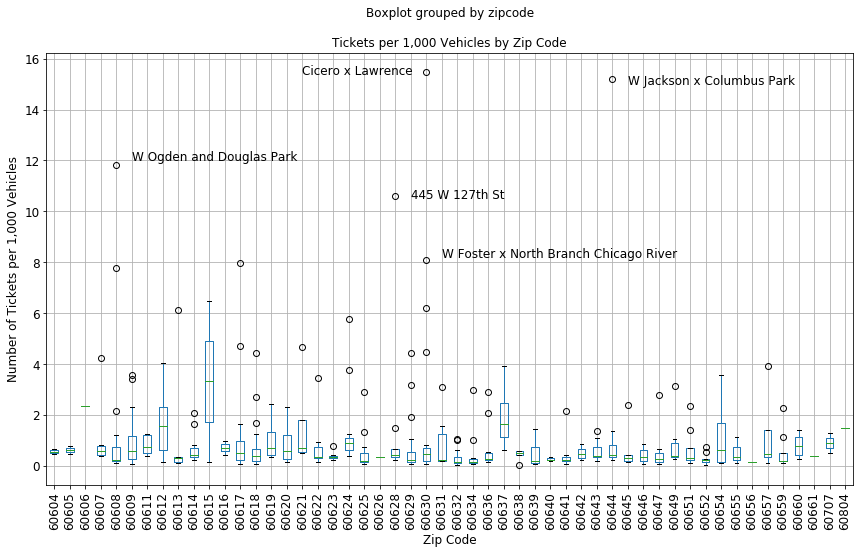

In [5]:
df.boxplot("Ticket per 1000 AADT", by="zipcode", figsize=(14, 8), fontsize=12)
plt.title("Tickets per 1,000 Vehicles by Zip Code")
plt.xlabel("Zip Code", fontsize=12)
plt.ylabel("Number of Tickets per 1,000 Vehicles", fontsize=12)
plt.xticks(rotation=90)

# annotate the top 5 locations
plt.annotate('Cicero x Lawrence', (17,15.4), fontsize=12)
plt.annotate('W Foster x North Branch Chicago River', (26,8.2), fontsize=12)
plt.annotate('W Jackson x Columbus Park', (38,15), fontsize=12)
plt.annotate('445 W 127th St', (24,10.5), fontsize=12)
plt.annotate('W Ogden and Douglas Park', (6,12), fontsize=12)

# save fig
plt.savefig("BoxPlotbyZipCode.png")

# show figure
plt.show()

### Maps

In [6]:
# Group data by zip code, convert zip code to text
count_zipcode = df.groupby('zipcode')[['Daily Avg', 'Ticket per 1000 AADT']].agg(['sum','mean'])
count_zipcode.columns = ['Daily Total', 'Daily Avg', 'Total per 1000 Vehicle', 'Avg per 1000 Vehicle']
count_zipcode = count_zipcode.reset_index()
# count_zipcode['zipcode'] = count_zipcode[['zipcode']].astype('int').applymap(str)
count_zipcode.head()

,zipcode,Daily Total,Daily Avg,Total per 1000 Vehicle,Avg per 1000 Vehicle
0,60604,13.231707,6.615854,1.109045,0.554523
1,60605,19.196440,9.598220,1.222703,0.611352
2,60606,17.740741,17.740741,2.334308,2.334308
3,60607,78.940283,13.156714,6.928695,1.154782
4,60608,255.110075,15.006475,26.355620,1.550331


In [7]:
# function to create map
# title = map title
# column_df = column name of ticket data to size the marker
# column_zip = column name of zipcode-summarized data to colorcode map
# marker_weights_adj = weight adjustment for marker size
# save_png = file name to save map

def map_zipcode(title, column_df, column_zip, marker_weights_adj, save_png):
    # create plot
    fig, ax = plt.subplots(figsize=(12,20))
    
    # Map Title
    plt.title(title, fontsize=16)
    
    # base map
    m = Basemap(resolution='i',
                projection='merc',
               llcrnrlat=41.643919, llcrnrlon=-87.940101,
               urcrnrlat=42.023022, urcrnrlon=-87.523984)
    m.fillcontinents(color='#f8f8fa', lake_color='#46bcec')
    
    # camera location marker
    for index, row in df.iterrows():
        # convert from long/latitude to x,y
        x, y = m([row['Lng']], [row['Lat']])
        
        # marker weights
        weights = (row[column_df] ** 0.5) * marker_weights_adj
        
        # add marker
        m.plot(x, y, 'bo', markersize=weights, alpha=0.8)
    
    # read zip code shapefile and merge with ticket data
    m.readshapefile('shapefile/zip_code','ZC_bound')
    df_polygon = pd.DataFrame({
        'shapes': [Polygon(np.array(shape), True) for shape in m.ZC_bound],
        'zip': [area['zip'] for area in m.ZC_bound_info]
    })
    df_polygon = df_polygon.merge(count_zipcode, 
                                  left_on='zip', right_on='zipcode',
                                  how='left')
    
    # color bar legend
    cmap = plt.get_cmap('Oranges')
    norm = Normalize()
    patch = PatchCollection(df_polygon.shapes, zorder=2)
    patch.set_facecolor(cmap(norm(df_polygon[column_zip].fillna(0).values)))
    ax.add_collection(patch)
    mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
    mapper.set_array(df_polygon[column_zip])
    plt.colorbar(mapper, shrink=0.4)

    # dummy point for legend label
    m.plot(x, y, 'bo', label='camera location')
    plt.legend(loc='upper right')
    
    # save map
    plt.tight_layout()
    fig.savefig(save_png, bbox_inches='tight')

    # Show map
    fig
    

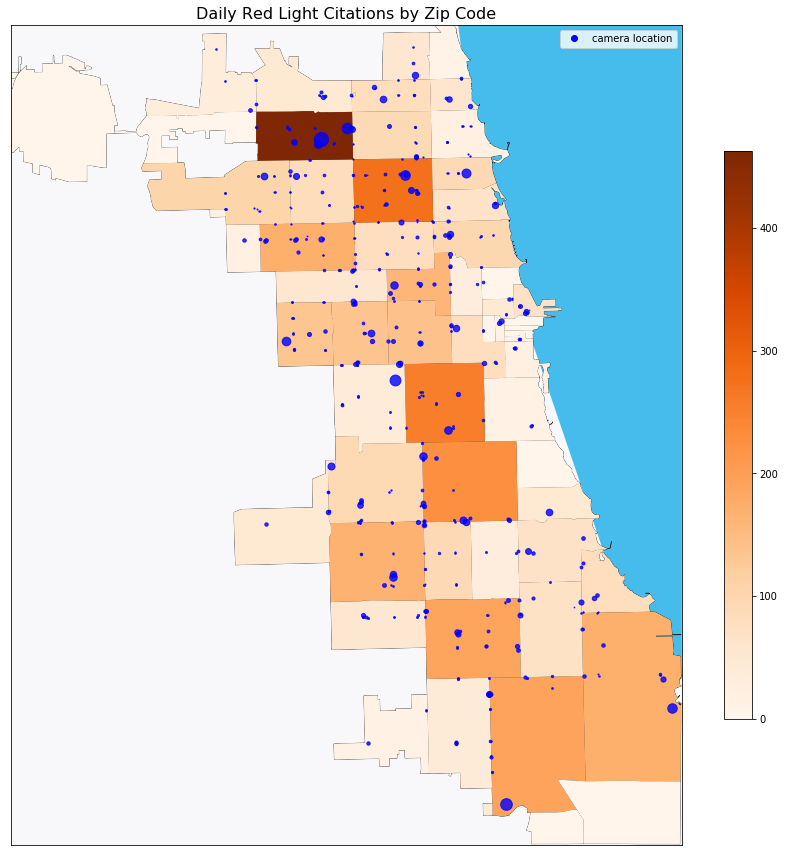

In [8]:
# Total Citations per Day by Zip Code
map_zipcode('Daily Red Light Citations by Zip Code', 'Daily Avg', 'Daily Total', 1, 'DailyTotal_ZipCode.png')

In [9]:
#![title](DailyTotal_ZipCode.png)

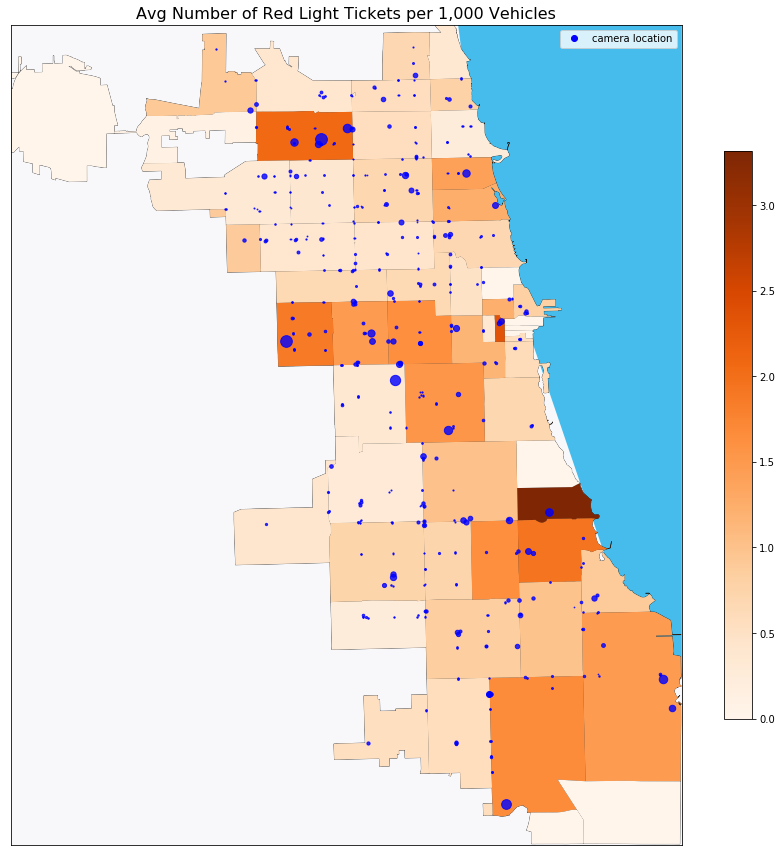

In [11]:
# Average Citations per 1000 Vehicles by Zip Code
map_zipcode('Avg Number of Red Light Tickets per 1,000 Vehicles', 'Ticket per 1000 AADT', 'Avg per 1000 Vehicle', 3, 'Total_ZipCode.png')

In [ ]:
#![title](Total_ZipCode.png)